# Vehicle Detection and Tracking
In this project, our goal is to implement a pipeline to identify vehicles in a video from a front-facing camera on a car.

The pipeline is broken into 3 steps
* Build a classifier: to decide whether a square image is a car or not
* Sliding windows technique to search for vehicles in images
* Vehicle tracking: once we have a high confidence vehicle detection, we can eventually estimate where it will appear in each subsequent frame

The first two steps is described in `vehicle_detection_p1_classifier.ipynb` and `vehicle_detection_p2_sliding_window.ipynb`. In this notebook we look at the final step, first let's load some useful modules

In [1]:
import glob
import os
import time
import numpy as np
import cv2
import pickle
from skimage.feature import hog

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Load trained models and seach windows

In [103]:
# first load trained model
trained_file = 'trained_model_luv.pkl'
with open(trained_file, 'rb') as f:
    trained_model = pickle.load(f)

clf = trained_model['clf']
feat_settings = trained_model['feat_settings']

# load search windows
windows_file = 'search_windows.pkl'
with open(windows_file, 'rb') as f:
    search_windows = pickle.load(f)

windows = search_windows['windows']
img_shape = search_windows['img_shape']

## Heat map filtering

The vehicle detection is done as following

* load each frame and compute the bounding-boxes that contain vehicle on each frame
* integrate the bounding-boxes for few seubsequent frames to create a heat-map

This is implemented in `pipeline.pipeline_single_img_memory`. Let's visualize it for few frames

In [104]:
from pipeline import pipeline_imgs
from utils import list_imgs, grid_view
max_frames=6
threshold=10
bboxes_setting= (img_shape, max_frames, threshold)

frame_imgs = list_imgs(['video_frame/project_video/'],'png')

imgs = [mpimg.imread(fn) for fn in frame_imgs[1032:1038]]
out_imgs, out_labels, cmaps = pipeline_imgs(imgs,
                                           windows,
                                           clf, 
                                           bboxes_setting,
                                           **feat_settings)

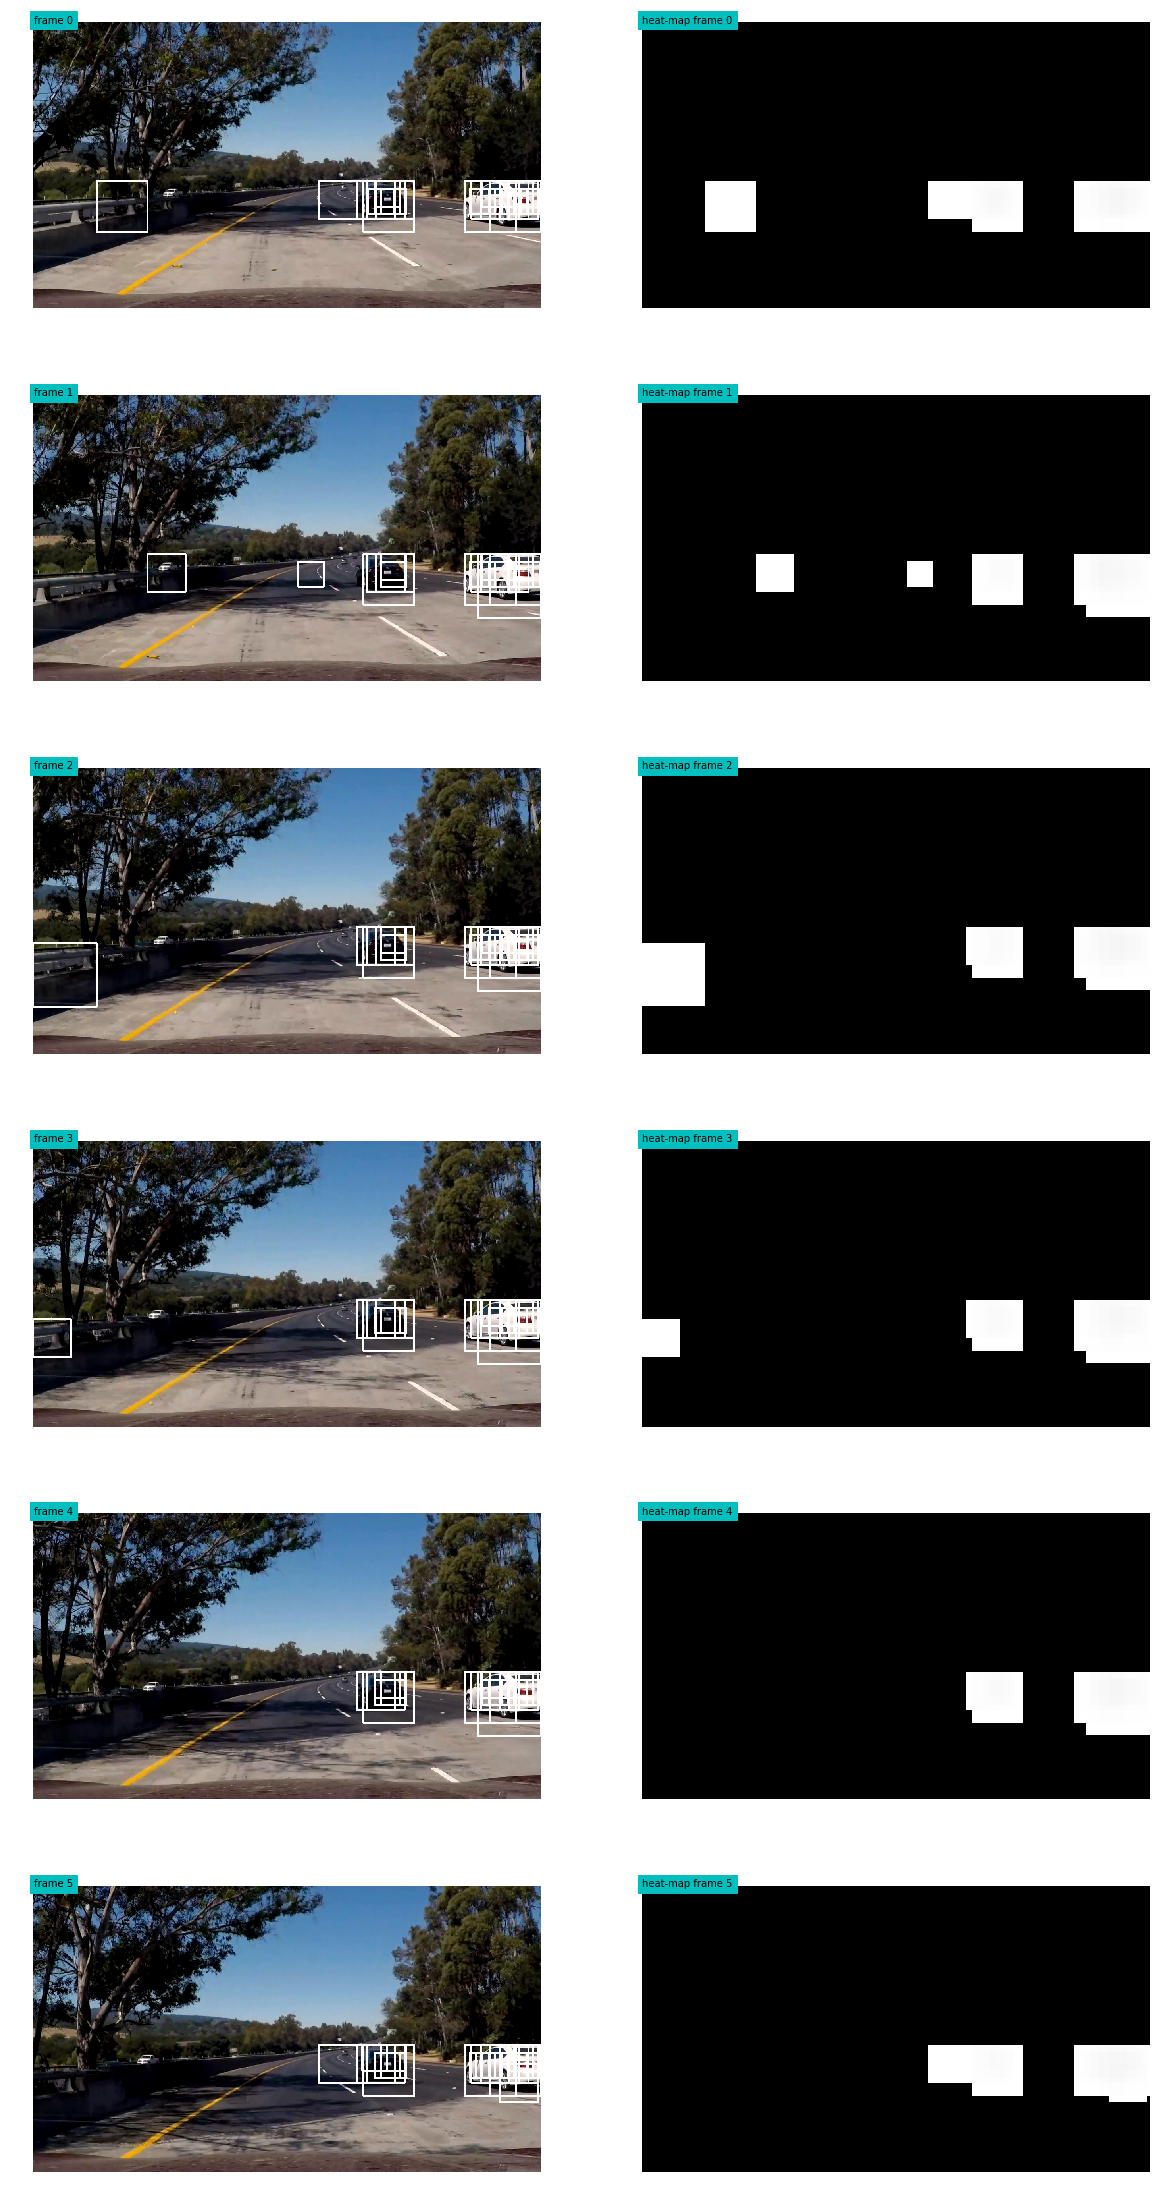

In [117]:
grid_view(out_imgs[:-2], out_labels[:-2], (20,40), nrows = len(out_imgs)//2-1, ncols=2, cmaps=cmaps[:-2])

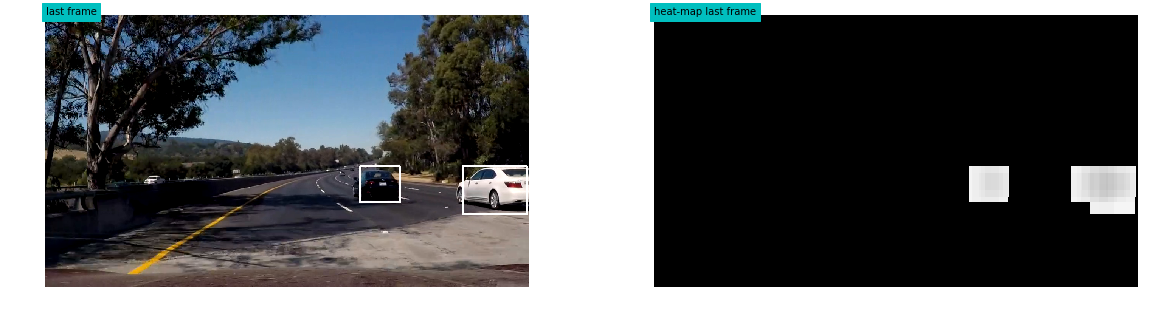

In [119]:
grid_view(out_imgs[-2:], out_labels[-2:], (20,5), nrows = 1, ncols=2, cmaps=cmaps[-2:])

### Test on Video
Regarding video, we iterate through frame and run above function to produce a video with tracked vehicles. This is implemented in `pipeline.pipeline_video_memory`.

Now let's test it on `test_video.mp4`

In [110]:
from pipeline import pipeline_video_memory

max_frames=6 
threshold=10
bboxes_setting= (img_shape, max_frames, threshold)


input_file  = 'test_video.mp4'
output_file = 'test_video_out.mp4'

In [111]:
pipeline_video_memory(input_file, 
                      output_file, 
                      windows,
                      clf, 
                      bboxes_setting,
                      **feat_settings)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:43<00:01,  1.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

File is saved to test_video_out.mp4


In [112]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

The result for `test_video.mp4` looks reasonable, let's apply above pipeline to detect vehicles in `project_video.mp4`

In [113]:
input_file  = 'project_video.mp4'
output_file = 'project_video_out.mp4'
max_frames = 6 
threshold  = 10
bboxes_setting= (img_shape, max_frames, threshold)

In [114]:
pipeline_video_memory(input_file, 
                      output_file, 
                      windows,
                      clf, 
                      bboxes_setting,
                      **feat_settings)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [24:09<00:01,  1.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

File is saved to project_video_out.mp4


In [116]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

We notice that there is some false-positive around seconds 40-43, we extract a sub-clip to verify the issue

In [108]:
from moviepy.editor import VideoFileClip
clip = VideoFileClip('project_video.mp4')
subclip = clip.subclip(39,42)
subclip_out = 'subclip_out.mp4'

max_frames = 6
threshold  = 10
bboxes_setting= (img_shape, max_frames, threshold)

pipeline_video_memory(subclip, 
                      subclip_out, 
                      windows,
                      clf, 
                      bboxes_setting,
                      **feat_settings)

[MoviePy] >>>> Building video subclip_out.mp4
[MoviePy] Writing video subclip_out.mp4


 99%|█████████▊| 75/76 [01:25<00:01,  1.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip_out.mp4 

File is saved to subclip_out.mp4


In [109]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(subclip_out))